In [1]:
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import seaborn as sns
import scvi
import glob
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.n_jobs = 16
scvi.train.Trainer(accelerator = 'mps')
sc.set_figure_params(dpi=100,dpi_save=800, figsize=(5,5), frameon=False)
%config InlineBackend.figure_format='retina'

Global seed set to 0
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Subset and recluster the nociceptive cells

In [111]:
mdata = mu.read("./Results_h5ad/02_mdata_mvi_Injury_state_edit.h5mu")

In [112]:
noci_mdata = mdata[mdata.obs.NociceptiveType == 'Nociceptors'].copy()

In [4]:
lvae = scvi.model.SCANVI.load('./scanvi_model')

INFO     File ./scanvi_model/model.pt already downloaded                                                           


In [9]:
mvi = scvi.model.MULTIVI.load('./multivi_model')

INFO     File ./multivi_model/model.pt already downloaded                                                          


/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [113]:
sc.pp.neighbors(noci_mdata, n_neighbors=100, use_rep="X_scANVI", metric='cosine')
sc.tl.umap(noci_mdata, min_dist=0.5)
sc.tl.leiden(noci_mdata, resolution=0.1)
noci_mdata.obsm['X_umapSCANVI'] = noci_mdata.obsm['X_umap'].copy()

In [114]:
noci_mdata.obs['subtype'] = noci_mdata.obs['scANVI_pred'].astype(str)

In [115]:
noci_mdata.obs['Time_new'] = noci_mdata.obs['Time'].str.strip('day').astype(float)

In [116]:
noci_mdata.obs[['mixed_currents', 'current_Type_1', 'current_Type_2']] = noci_mdata['rna'].obs[['mixed_currents', 'current_Type_1', 'current_Type_2']].copy()

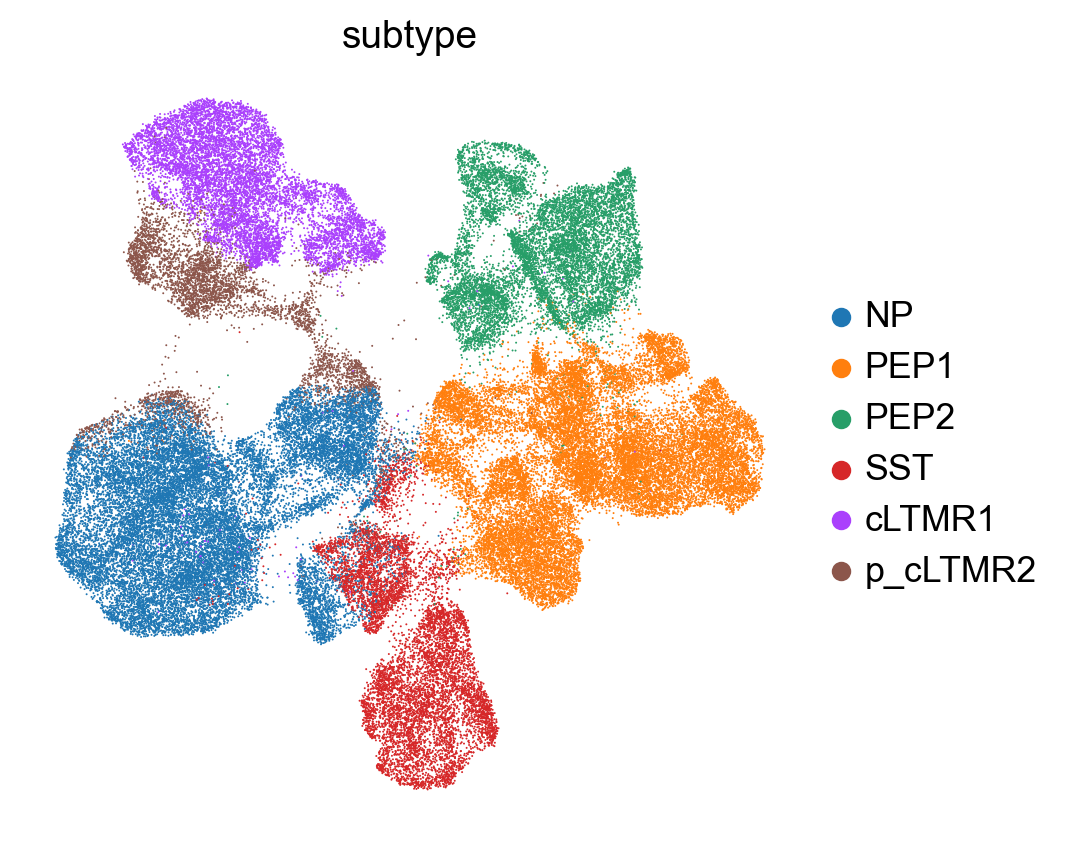

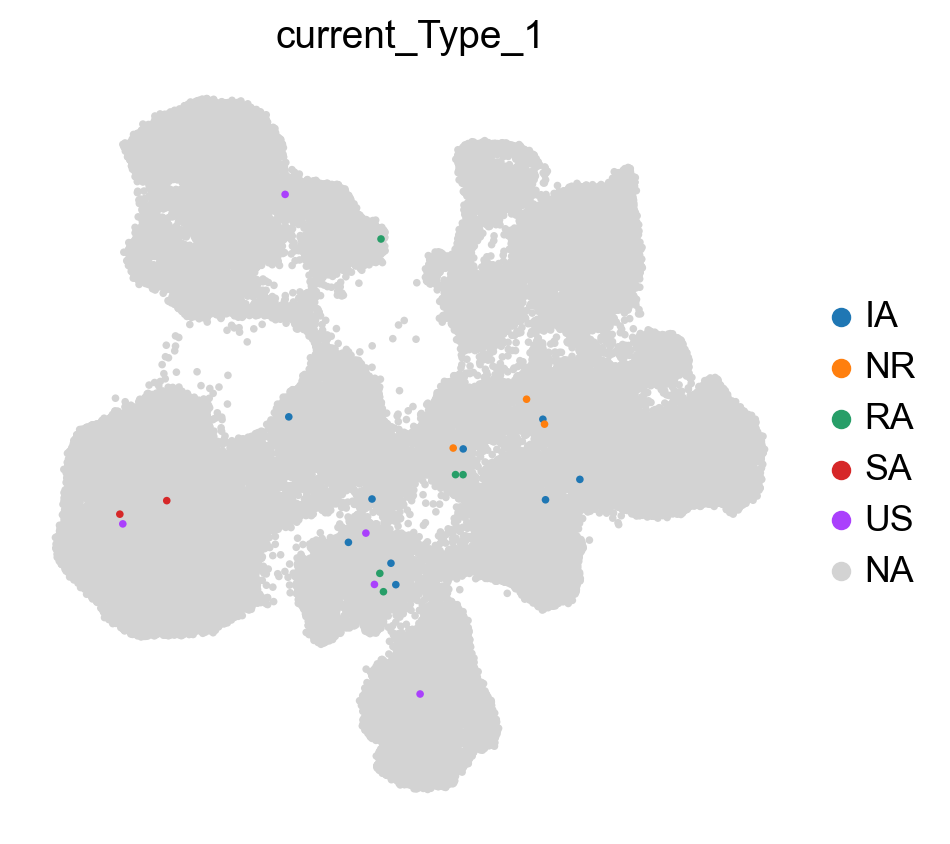

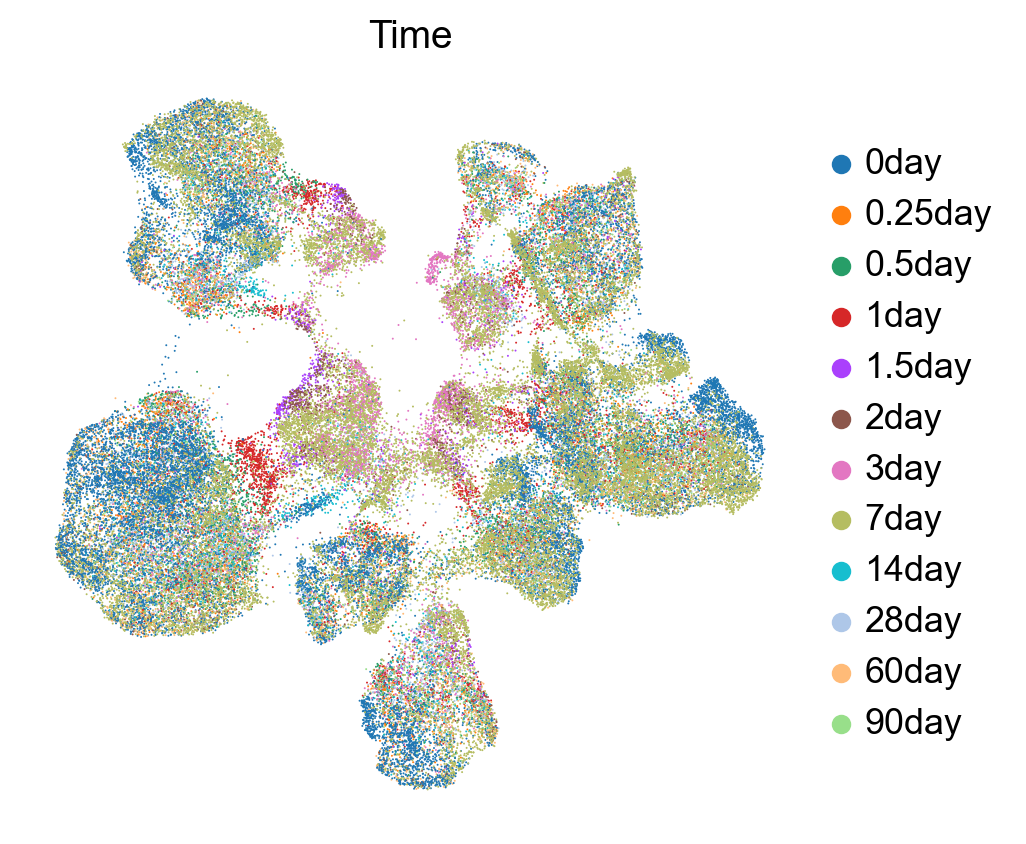

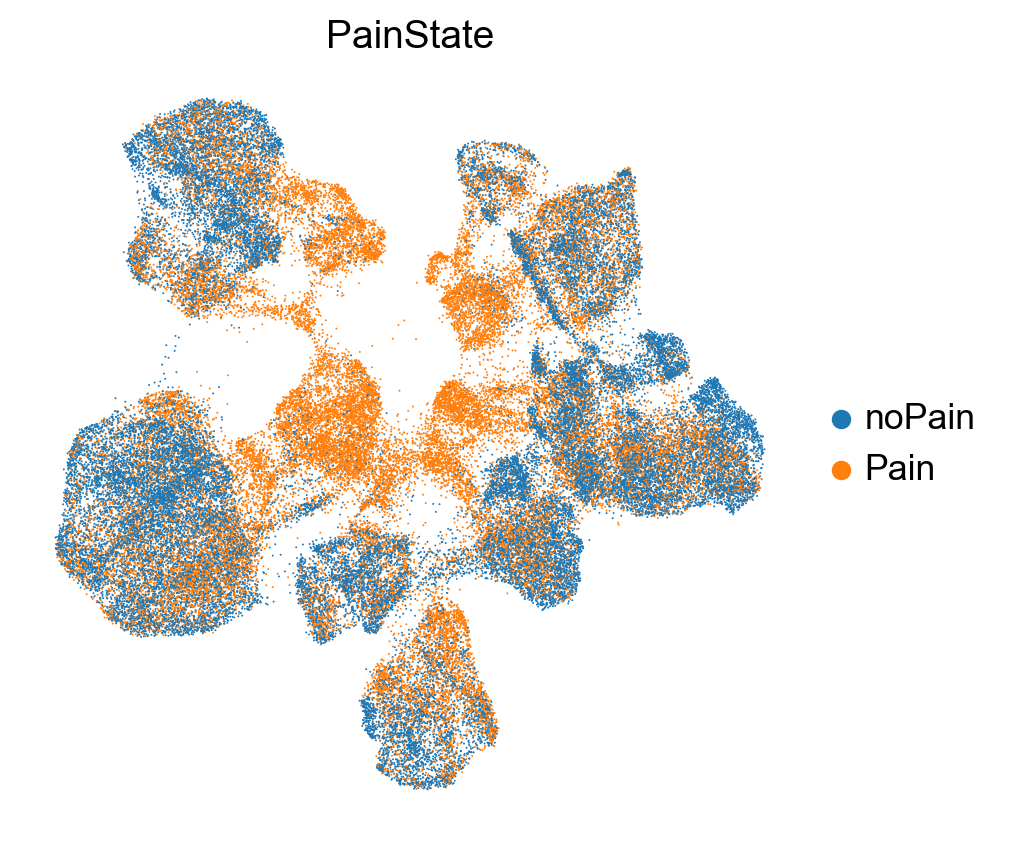

In [118]:
sc.set_figure_params(dpi=100, dpi_save=800, figsize=(5,5), frameon=False)
mu.pl.umap(noci_mdata, color='subtype', size=2)
mu.pl.umap(noci_mdata, color='current_Type_1', size=30)
mu.pl.umap(noci_mdata, color='Time', size=2)
mu.pl.umap(noci_mdata, color='PainState', size=2)

In [121]:
noci_mdata.write('./Results_h5ad/05_noci_mdata.h5mu')

/Users/pax/miniconda3/envs/injury_atlas/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[key] = c


In [3]:
noci_mdata = mu.read('./Results_h5ad/05_noci_mdata.h5mu')

In [122]:
sc.tl.leiden(noci_mdata, resolution=0.2)

In [123]:
sc.tl.leiden(noci_mdata, resolution=0.2, restrict_to=('leiden', ['0']), key_added='leiden_subcluster')
sc.tl.leiden(noci_mdata, resolution=0.3, restrict_to=('leiden_subcluster', ['2']), key_added='leiden_subcluster')
sc.tl.leiden(noci_mdata, resolution=0.2, restrict_to=('leiden_subcluster', ['3']), key_added='leiden_subcluster')
sc.tl.leiden(noci_mdata, resolution=0.3, restrict_to=('leiden_subcluster', ['4']), key_added='leiden_subcluster')
sc.tl.leiden(noci_mdata, resolution=0.4, restrict_to=('leiden_subcluster', ['5']), key_added='leiden_subcluster')
sc.tl.leiden(noci_mdata, resolution=0.2, restrict_to=('leiden_subcluster', ['6']), key_added='leiden_subcluster')

In [44]:
noci_mdata['rna'].X = noci_mdata['rna'].layers['scVI_gene'].copy()

In [53]:
sc.tl.score_genes(noci_mdata['rna'], gene_list=['Atf3','Gal','Sprr1a'], score_name='Injury_score', use_raw=False)

In [54]:
noci_mdata.obs['Injury_score'] = noci_mdata['rna'].obs.Injury_score

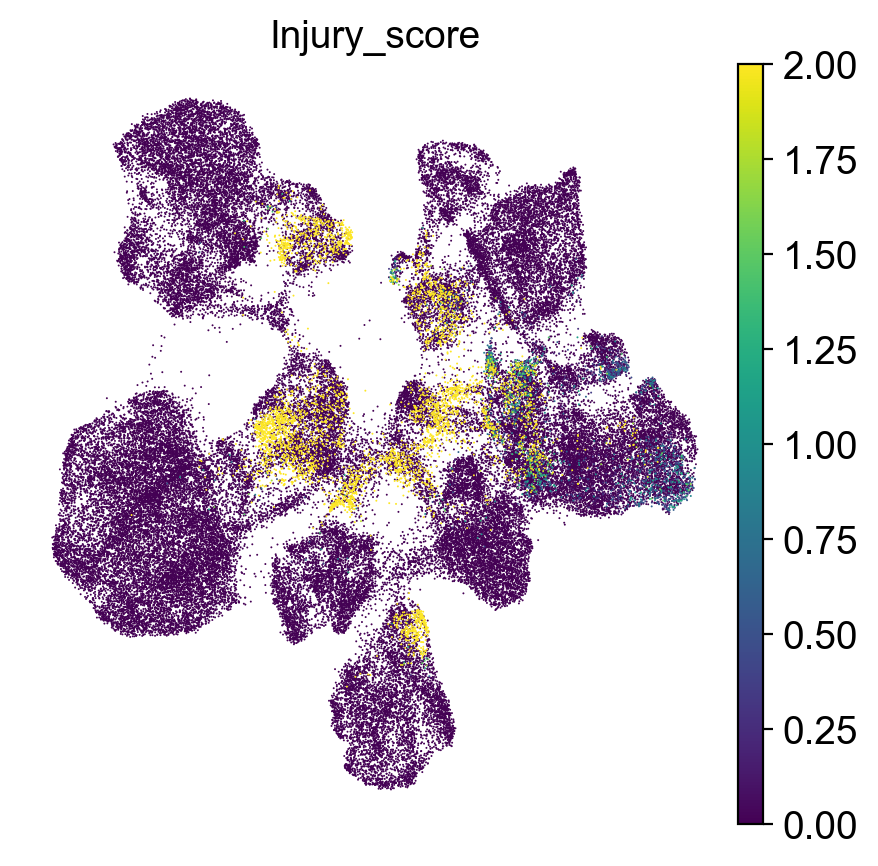

In [63]:
mu.pl.umap(noci_mdata, color=['Injury_score'], size=2, vmin=0, vmax=2)

In [134]:
noci_mdata.write('./Results_h5ad/05_noci_mdata_subcluster.h5mu')

In [2]:
noci_mdata = mu.read('./Results_h5ad/05_noci_mdata_subcluster.h5mu')

# Compute entropy on the nociceptive cells

In [3]:
noci_rna = noci_mdata['rna'].copy()

In [6]:
# remove all the data in all slots and only keep the .X slot to save memory when loaded into rpy2
del noci_rna.obs
del noci_rna.var
del noci_rna.uns
del noci_rna.obsm
del noci_rna.layers['counts']

In [7]:
import rpy2.rinterface_lib.callbacks
import logging

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import anndata2ri

In [8]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [9]:
%%R
# Load all the R libraries we will be using in the notebook
library(SingleCellExperiment)
library(dplyr)
library(Matrix)
library(SCENT)
library(Seurat)
library(org.Hs.eg.db)

data(net17Jan16)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [10]:
%%R
# match the gene names in net17Jan16.m with mm gene names
net17Jan16.gene_table <- mapIds(org.Hs.eg.db, keys = rownames(net17Jan16.m), keytype = "ENTREZID", column="SYMBOL")
net17Jan16.gene_table <- as.data.frame(net17Jan16.gene_table)
net17Jan16.gene_table <- na.omit(net17Jan16.gene_table)

net17Jan16.df <- as.data.frame(net17Jan16.m)
net17Jan16.df <- net17Jan16.df[rownames(net17Jan16.df) %in% rownames(net17Jan16.gene_table), colnames(net17Jan16.df) %in% rownames(net17Jan16.gene_table)]
rownames(net17Jan16.df) <- make.unique(net17Jan16.gene_table$net17Jan16.gene_table)
colnames(net17Jan16.df) <- make.unique(net17Jan16.gene_table$net17Jan16.gene_table)

In [11]:
%%R
orth <- orthologsBioMART::findOrthologsHsMm(from_filters = "hgnc_symbol",
  from_values = rownames(net17Jan16.df), 
  to_attributes = "external_gene_name")

external_gene_name <- orth$hgnc_symbol
names(external_gene_name) <- orth$external_gene_name
external_gene_name <- external_gene_name[!duplicated(names(external_gene_name))]


vec <- lapply(rownames(net17Jan16.df), FUN = function(x){
  names(external_gene_name)[match(x, external_gene_name)]
})

vec <- unlist(vec)
na.vec <- is.na(vec)
vec <- vec[!na.vec]
net17Jan16.df <- net17Jan16.df[!na.vec,!na.vec]
rownames(net17Jan16.df) <- vec
colnames(net17Jan16.df) <- vec

In [29]:
%%R -i noci_rna -o ccat

# Get the gene expression matrix
mtx <- assay(noci_rna,'scVI_gene')
mtx <- log2(mtx)

# convert gene names in net17Jan16.m to mouse ortholog gene names
net17Jan16.gene_table <- mapIds(org.Hs.eg.db, keys = rownames(net17Jan16.m), keytype = "ENTREZID", column="SYMBOL")
net17Jan16.gene_table <- as.data.frame(net17Jan16.gene_table)
net17Jan16.gene_table <- na.omit(net17Jan16.gene_table)

net17Jan16.df <- as.data.frame(net17Jan16.m)
net17Jan16.df <- net17Jan16.df[rownames(net17Jan16.df) %in% rownames(net17Jan16.gene_table), colnames(net17Jan16.df) %in% rownames(net17Jan16.gene_table)]
rownames(net17Jan16.df) <- make.unique(net17Jan16.gene_table$net17Jan16.gene_table)
colnames(net17Jan16.df) <- make.unique(net17Jan16.gene_table$net17Jan16.gene_table)

# Get orthologs
orth <- orthologsBioMART::findOrthologsHsMm(from_filters = "hgnc_symbol",
  from_values = rownames(net17Jan16.df), 
  to_attributes = "external_gene_name")

# Create vector of mouse ortholog gene names
external_gene_name <- orth$hgnc_symbol
names(external_gene_name) <- orth$external_gene_name
external_gene_name <- external_gene_name[!duplicated(names(external_gene_name))]

vec <- lapply(rownames(net17Jan16.df), FUN = function(x){
  names(external_gene_name)[match(x, external_gene_name)]
})

vec <- unlist(vec)
na.vec <- is.na(vec)
vec <- vec[!na.vec]

net17Jan16.df <- net17Jan16.df[!na.vec,!na.vec]
rownames(net17Jan16.df) <- vec
colnames(net17Jan16.df) <- vec
net17Jan16.m <- as.sparse(net17Jan16.df)

# calculate CCAT from log count
ccat <- CompCCAT(exp = mtx, ppiA = net17Jan16.m)

In [90]:
pheno = noci_mdata.obs.Injury_state.to_list()

In [93]:
%%R -i pheno -o pot_df
pot.o <- InferPotencyStates(potest.v=ccat, pheno.v = pheno, type='CCAT')
pot_df <- pot.o$distr

[1] "Fit Gaussian Mixture Model to Z-transformed CCAT values"
fitting ...
  |======================================================================| 100%
[1] "Identified 4 potency states"
[1] "Compute Shannon (Heterogeneity) Index for each Phenotype class"
[1] "Done"


In [95]:
%%R
pot.o$distr

          ordpotS.v
pheno.v        1     2     3     4
  Acute    16224  9843 16269  4462
  Chronic     82   570  1171   867
  Recovery    56  1997  4555  1183
  RefState  1958  8605  5826  2535


In [30]:
noci_mdata.obs['Entropy'] = ccat

In [36]:
noci_mdata.write('./Results_h5ad/05_noci_mdata_subcluster_CCAT.h5mu')

In [31]:
sc.pp.calculate_qc_metrics(noci_mdata['rna'], qc_vars=['mt'], percent_top=None, log1p=False, inplace=True, layer='counts')

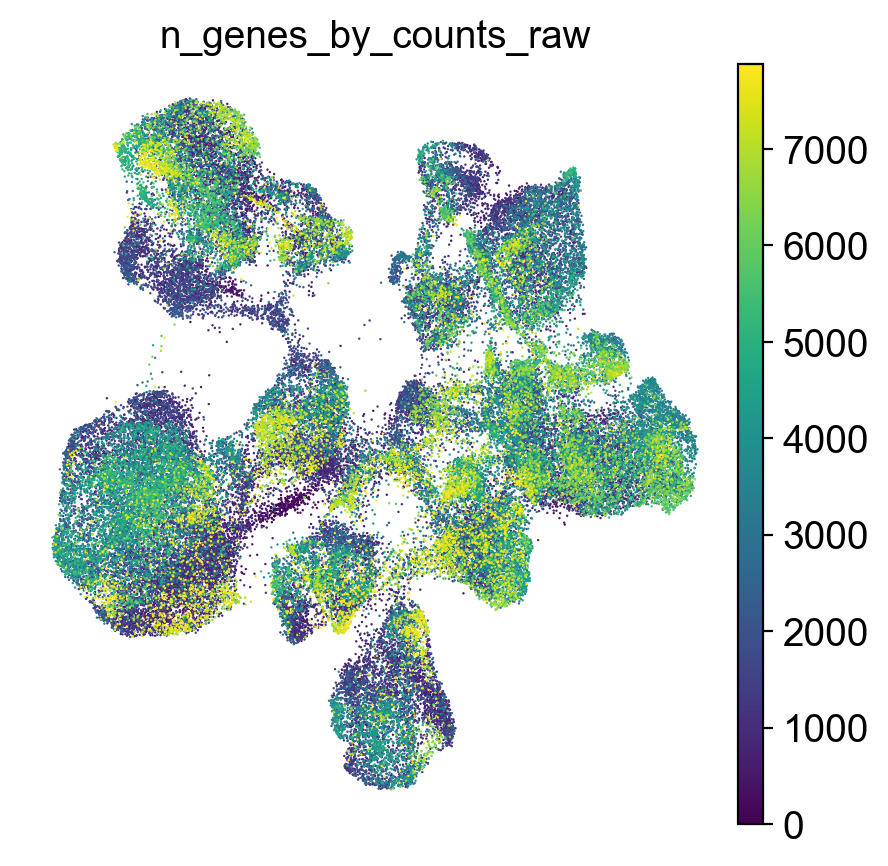

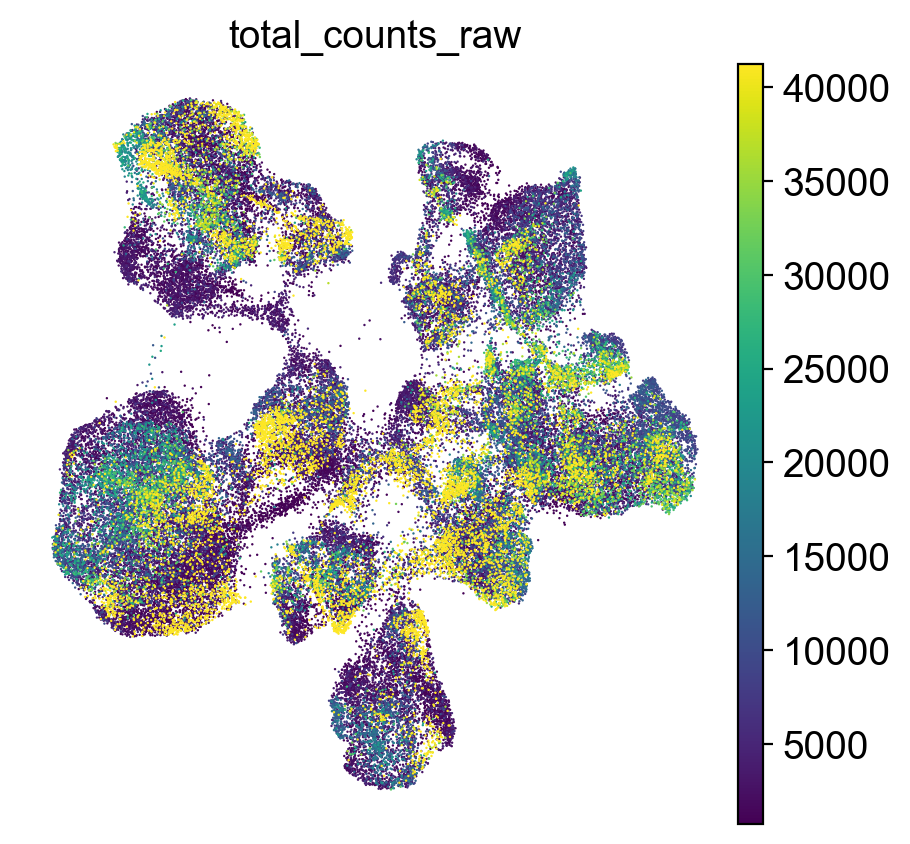

In [35]:
sc.pl.umap(noci_mdata['rna'], color=['n_genes_by_counts'], size=3, vmin=0, vmax='p99', cmap='viridis', title='n_genes_by_counts_raw')
sc.pl.umap(noci_mdata['rna'], color=['total_counts'], size=3, vmin='p5', vmax='p90', cmap='viridis', title='total_counts_raw')

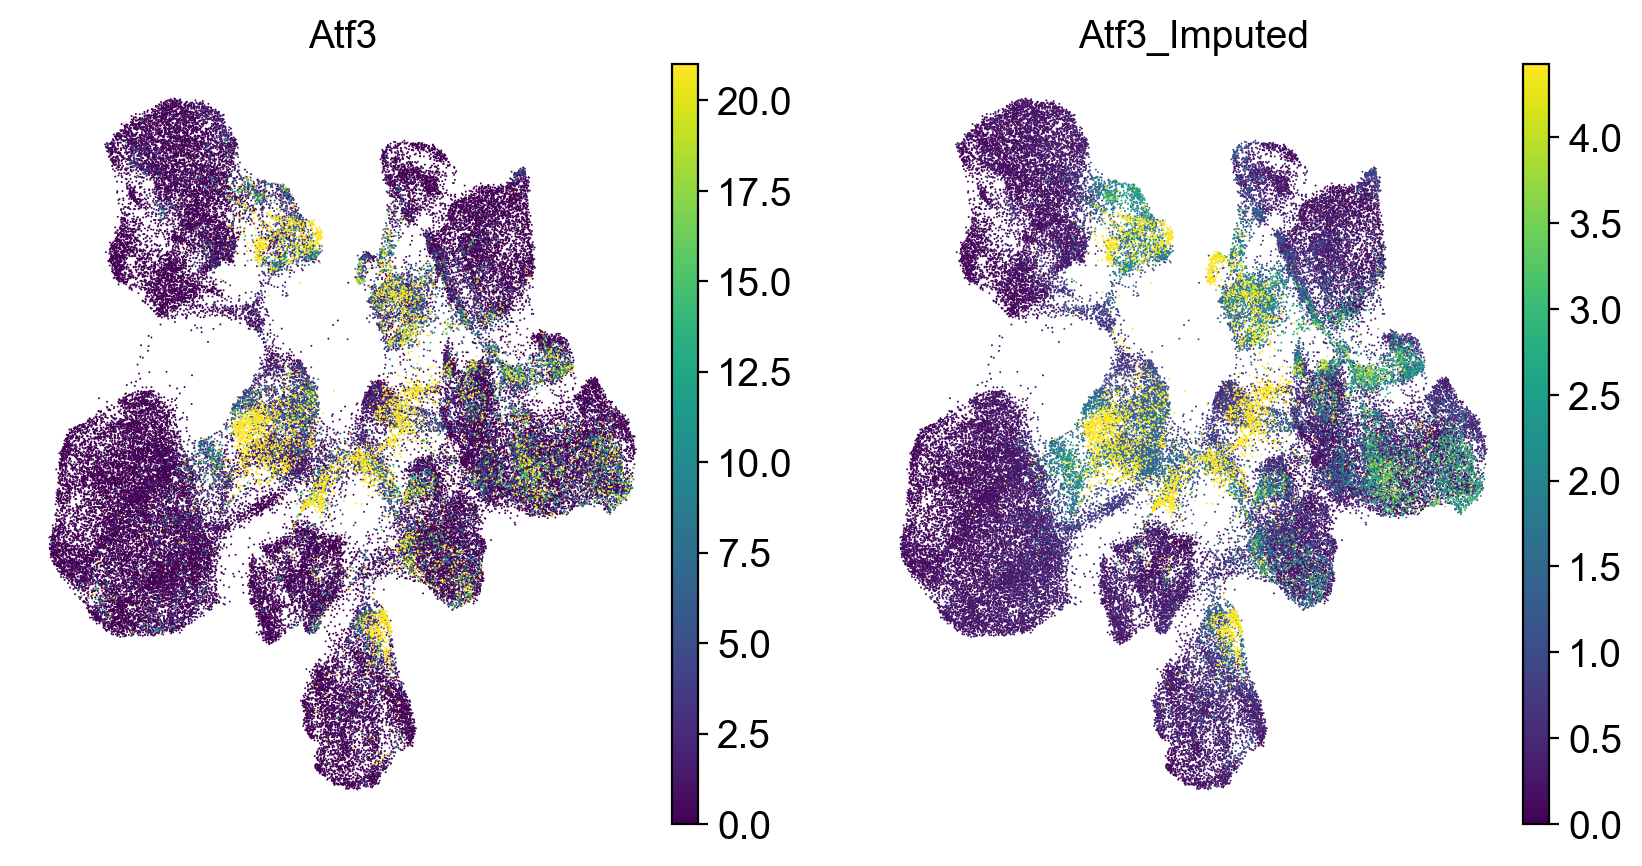

In [167]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
mu.pl.umap(noci_mdata, color=["Atf3"], size=2, layer='counts', ax=ax[0], show=False, vmax='p95')
mu.pl.umap(noci_mdata, color=["Atf3"], size=2, layer='scVI_gene', ax=ax[1], show=False, vmin=0, vmax='p95', title='Atf3_Imputed')
plt.show()